In [1]:
from src.net import FCOS
from src.encode import decode_fcos, visualize, visualize_feature_maps
from PIL import Image
import numpy as np
from src.labelme import LabelMeDataset
import torch
import random
from matplotlib import pyplot as plt
from os import path, listdir, walk

In [2]:

def search_images(dir):
    images = []
    for root, _, files in walk(dir):
        for file in files:
            file = path.join(root, file)
            try:
                image = Image.open(file)
                images.append(file)
                image.close()
            except Exception:
                pass
    return images


In [3]:
def prepare_input(image, W, H):
    image = image.resize((W, H), Image.Resampling.LANCZOS).convert("RGB")
    image_np = np.array(image, dtype="float32") / 255
    image_np = image_np.transpose(2, 0, 1)
    return image_np

In [4]:

# images = search_images("./dog-and-cat/")
images = search_images("./data/marmot_eng/")

In [68]:
image_size = (800, 999999999999)
class2str = ["dog", "cat"]
num_classes = len(class2str)

def transform(image, boxes, classes):
    return encode_fcos(image, boxes, classes, W=1024, H=1024, C=num_classes)


dataset = LabelMeDataset("index.txt", class2str, transform=transform)
model = FCOS(128, 2)
model.load_state_dict(torch.load("model.pt"), strict=False)
model = model.eval()


[0.9305211901664734]


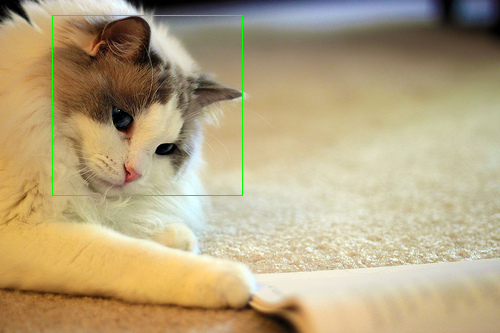

In [69]:
# image = Image.open(random.choice(images))
image = Image.open("./dog-and-cat/Cats_Test196.png")
image_np = prepare_input(image, 1024, 1024)
image_ts = torch.tensor(image_np).unsqueeze(0)
with torch.no_grad():
    rgs_maps, ctn_maps, cls_maps = model(image_ts)
    ctn_maps = [torch.sigmoid(c).numpy()[0] for c in ctn_maps]
    cls_maps = [torch.sigmoid(c).numpy()[0] for c in cls_maps]
    rgs_maps = [(r).numpy()[0] for r in rgs_maps]

boxes, classes, scores = decode_fcos(rgs_maps, ctn_maps, cls_maps, min_score=0.5, nms_threshold=0.6)
print(scores)
visualize(image, boxes, classes)

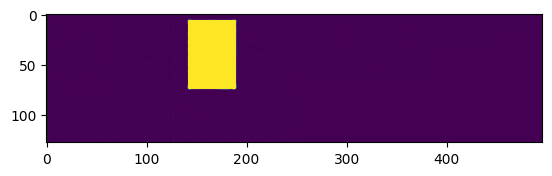

In [70]:
visualize_feature_maps(cls_maps)

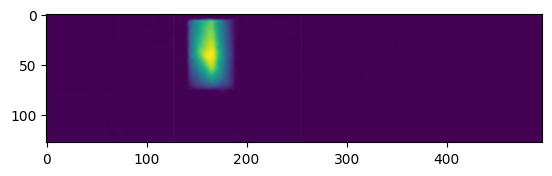

In [71]:
visualize_feature_maps(ctn_maps)

0.0 0.025824992


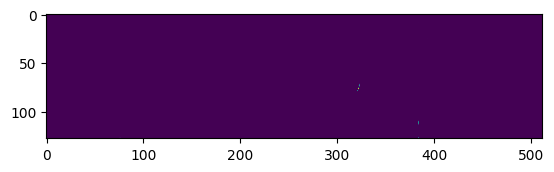

0.0 68.74812


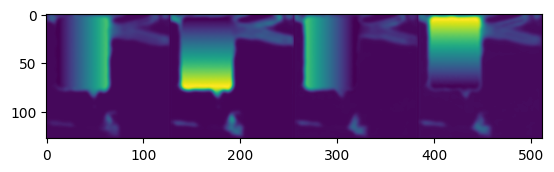

In [72]:
for rmap in rgs_maps[0]:
    rmap = np.concatenate(list(rmap), -1)
    # rmap = np.concatenate(list(rmap), -2)
    print(rmap.min(), rmap.max())
    
    plt.imshow(rmap)
    plt.show()

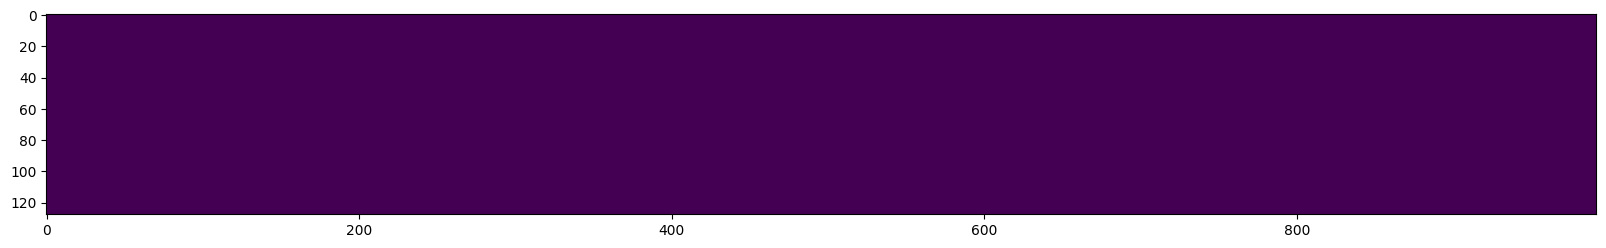

In [11]:
plt.figure(figsize=(20, 20))
visualize_feature_maps(rgs_maps, normalize=False)